In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from collections import Counter
from sklearn.metrics.pairwise import pairwise_distances as PWD
from scipy.stats import hypergeom
statf = hypergeom.sf
from math import log
import scipy.spatial as sp, scipy.cluster.hierarchy as hc


### Load homology gene families

In [2]:
genefams = pd.read_csv("./data/gene_families_table.tsv.gz",
                      sep='\t')
genefams = genefams.applymap(lambda x: x.split(":") if x==x else x)

genefamsC = genefams.applymap(lambda x: len(x) if x==x else 0)
genefams.head(2)

,Bbe,Bla,Cmi,Dre,Gga,Hsa,Mmu,Ola,Sko,Spu,Xtr,Dme
0,[052260F],[BL61971],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,[BL20829],NaN,NaN,NaN,NaN,NaN,NaN,NaN,[WHL22.255708],NaN,NaN


In [3]:
genefamsC.head(2)

,Bbe,Bla,Cmi,Dre,Gga,Hsa,Mmu,Ola,Sko,Spu,Xtr,Dme
0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,0,0


In [4]:
# We construct a single dictionary that maps gene IDs to family IDs
# genes from different species share the same ID if they belong in the same homology fmaily
fam_of = {}
for rowi,row in genefams[['Bla']].dropna().iterrows():
    for gene in row.Bla:
        fam_of[gene]= rowi
for rowi,row in genefams[['Dre']].dropna().iterrows():
    for gene in row.Dre:
        fam_of[gene]= rowi

### Load the mfuzz results

These tables map gene IDs to MFUZZ cluster numbers

In [5]:
dan_cl = pd.read_csv("./data/mfuzz/mfuzz_geneToCluster_dan.txt.gz", sep='\t')
dan_cl.columns = ['geneID','clusterID']
dan_cl_d = dict(dan_cl[['geneID','clusterID']].to_records(index=False))
bla_cl = pd.read_csv("./data/mfuzz/mfuzz_geneToCluster_bla.txt.gz", sep='\t')
bla_cl.columns = ['geneID','clusterID']
bla_cl_d = dict(bla_cl[['geneID','clusterID']].to_records(index=False))

In [6]:
dan_cl.head()

,geneID,clusterID
0,ENSDARG00000020850,20
1,ENSDARG00000098739,22
2,ENSDARG00000017624,23
3,ENSDARG00000053254,10
4,ENSDARG00000033683,10


### The core computation

Here we go through our data. We compare all pairwise combinations of clusters    
between the two species and compute the survival function of a hypergeometric distribution.    
This is equivalent to an upper tail test.    
      
We consider the total number of gene families as the Population,    
the number of different gene families in the zebrafish cluster is the Sample Size,
the number of different gene families in the amphioxus cluster is the Success in Population,
the number of common gene families between the two clusters is the Success in Sample

In [7]:
gimme_fams = lambda g: [fam_of.get(x) for x in g.geneID.tolist()]
gene_POP = len(genefams)

# PVs is the table that will hold the Pvalues
PVs = pd.DataFrame()
# hits will record the number of common gene families between clusters
hits = pd.DataFrame()
# hl will be a detailed table
hl = []

for gn,g  in dan_cl.groupby('clusterID'):
    for bgn,bg  in bla_cl.groupby('clusterID'):
        fams = set(gimme_fams(g))
        bfams = set(gimme_fams(bg))
        
        gene_SS = len(fams) # number of zebra families here
        gene_SIP = len(bfams) # number of amphi gene families here
        
        gene_SIS = len(bfams.intersection(fams))
        
        if gene_SIS>0:
            PV = statf(gene_SIS,  gene_POP,  gene_SS, gene_SIP)
            hits.loc[gn, bgn] = gene_SIS
            hl.append( (gn, bgn, gene_SIS,gene_SS, gene_SIP, -log(PV,10)) )
            
        else:
            PV =1 
            jacc = 0
            hl.append( (gn, bgn, gene_SIS,gene_SS, gene_SIP, 0 ) )
            
        PVs.loc[gn, bgn] = PV
        

In [8]:
# our detailed table for inspection of the results
hl = pd.DataFrame(hl)
hl.columns = ['Dre Cluster #', 'Bla cluster #', 'Overlapping orthologues',
              'Dre genes in cluster','Bla genes in cluster','-log(pvalue) of hypergeom. test']
hl.head()

,Dre Cluster #,Bla cluster #,Overlapping orthologues,Dre genes in cluster,Bla genes in cluster,-log(pvalue) of hypergeom. test
0,1,1,8,435,283,0.919668
1,1,2,44,435,310,24.793323
2,1,3,20,435,279,6.572917
3,1,4,2,435,287,0.031037
4,1,5,11,435,315,1.571135


### Clustering:

In [11]:
# get the -log(x,10) of the pvalues:
mPVs_uncl = PVs.applymap(lambda x: -log(x,10) ).copy()
# clipping the very high pvalues to 25 gives better clustering
mPVs = mPVs_uncl.clip(upper=25,lower=0)

# Make  manual hierarchical linkage objects for better control of the clustering:
linkage_rows = hc.linkage(
        sp.distance.squareform(
            PWD(  mPVs.values, metric='correlation'), 
            checks=False), 
        method='average')

linkage_cols = hc.linkage(sp.distance.squareform(PWD(  mPVs.T.values, metric='correlation'), checks=False), method='average')

### The plot:

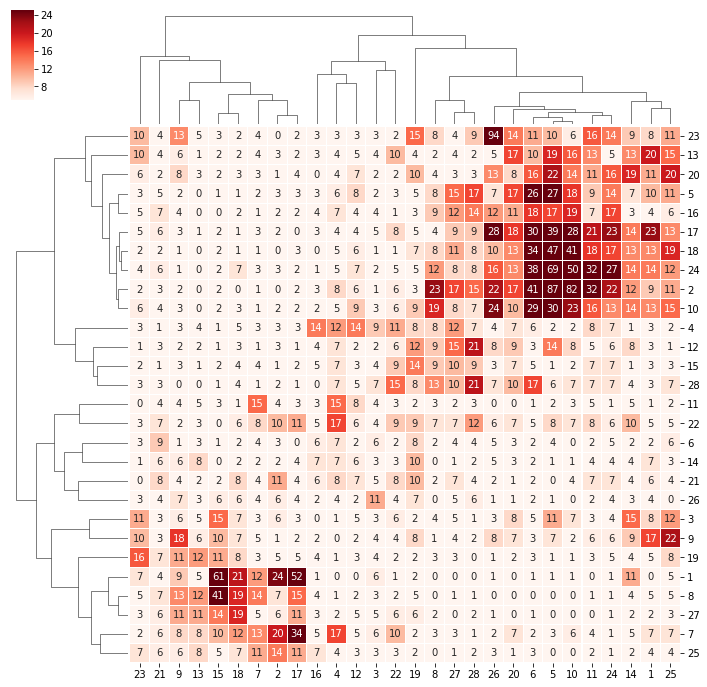

In [12]:

geneHM = sns.clustermap( 
                      mPVs_uncl.astype(int),
                      row_linkage = linkage_rows,
                      col_linkage = linkage_cols,
                      linewidths=0.01,
                      figsize =(12,12),
                      cmap='Reds',
                      vmax=25, 
                        vmin=5,
                        annot = True
                      )

_ = plt.setp(geneHM.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

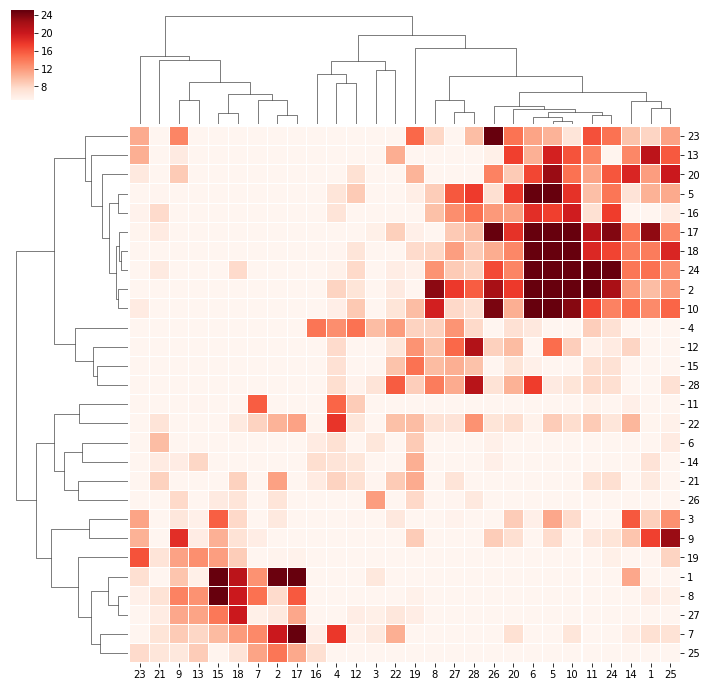

In [13]:
# The plot without numbers:
geneHM = sns.clustermap( mPVs,
                      row_linkage = linkage_rows,
                      col_linkage = linkage_cols,
                      linewidths=0.01,
                      figsize =(12,12),
                      cmap='Reds',
                      vmax=25, 
                        vmin=5

                      )

_ = plt.setp(geneHM.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)